# MetaSDF & Meta-SIREN

This is a colab to explore MetaSDF, and its applications to rapidly fit neural implicit representations.

Make sure to switch the runtime type to "GPU" under "Runtime --> Change Runtime Type"!

We will show you how to run two experiments using gradient-based meta-learning: 
* [Fitting an image in 3 gradient descent steps with SIREN](#section_1)
* [Fitting 2D Signed Distance Functions of MNIST digits](#section_2)

Let's go! 

First, the imports:

In [ ]:
import os
import torch

import numpy as np
import matplotlib.pyplot as plt

import torchvision
from torchvision import transforms
import scipy.ndimage
from torch import nn
from collections import OrderedDict, Mapping
from torch.utils.data import DataLoader, Dataset

from torch.nn.init import _calculate_correct_fan

For meta-learning, we're using the excellent "Torchmeta" library. We have to install it:

In [ ]:
!pip install torchmeta
from torchmeta.modules import (MetaModule, MetaSequential, MetaLinear)

We're now ready to implement a few neural network layers: Fully connected networks, and SIREN.

In [9]:
class BatchLinear(nn.Linear, MetaModule):
    '''A linear meta-layer that can deal with batched weight matrices and biases, as for instance output by a
    hypernetwork.'''
    __doc__ = nn.Linear.__doc__

    def forward(self, input, params=None):
        if params is None:
            params = OrderedDict(self.named_parameters())

        bias = params.get('bias', None)
        weight = params['weight']

        output = input.matmul(weight.permute(*[i for i in range(len(weight.shape)-2)], -1, -2))
        output += bias.unsqueeze(-2)
        return output


class MetaFC(MetaModule):
    '''A fully connected neural network that allows swapping out the weights, either via a hypernetwork
    or via MAML.
    '''
    def __init__(self, in_features, out_features,
                 num_hidden_layers, hidden_features,
                 outermost_linear=False):
        super().__init__()

        self.net = []
        self.net.append(MetaSequential(
            BatchLinear(in_features, hidden_features),
            nn.ReLU(inplace=True)
        ))

        for i in range(num_hidden_layers):
            self.net.append(MetaSequential(
                BatchLinear(hidden_features, hidden_features),
                nn.ReLU(inplace=True)
            ))

        if outermost_linear:
            self.net.append(MetaSequential(
                BatchLinear(hidden_features, out_features),
            ))
        else:
            self.net.append(MetaSequential(
                BatchLinear(hidden_features, out_features),
                nn.ReLU(inplace=True)
            ))

        self.net = MetaSequential(*self.net)
        self.net.apply(init_weights_normal)

    def forward(self, coords, params=None, **kwargs):
        '''Simple forward pass without computation of spatial gradients.'''
        output = self.net(coords, params=self.get_subdict(params, 'net'))
        return output


class SineLayer(MetaModule):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True, is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = float(omega_0)

        self.is_first = is_first

        self.in_features = in_features
        self.linear = BatchLinear(in_features, out_features, bias=bias)
        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                            1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                            np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input, params=None):
        intermed = self.linear(input, params=self.get_subdict(params, 'linear'))
        return torch.sin(self.omega_0 * intermed)


class Siren(MetaModule):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30., special_first=True):
        super().__init__()
        self.hidden_omega_0 = hidden_omega_0

        layer = SineLayer

        self.net = []
        self.net.append(layer(in_features, hidden_features,
                              is_first=special_first, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(layer(hidden_features, hidden_features,
                                  is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = BatchLinear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / 30.,
                                             np.sqrt(6 / hidden_features) / 30.)
            self.net.append(final_linear)
        else:
            self.net.append(layer(hidden_features, out_features, is_first=False, omega_0=hidden_omega_0))

        self.net = nn.ModuleList(self.net)

    def forward(self, coords, params=None):
        x = coords

        for i, layer in enumerate(self.net):
            x = layer(x, params=self.get_subdict(params, f'net.{i}'))

        return x
    
    
def init_weights_normal(m):
    if type(m) == BatchLinear or nn.Linear:
        if hasattr(m, 'weight'):
            torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if hasattr(m, 'bias'):
            m.bias.data.fill_(0.)
            
            
def get_mgrid(sidelen):
    # Generate 2D pixel coordinates from an image of sidelen x sidelen
    pixel_coords = np.stack(np.mgrid[:sidelen,:sidelen], axis=-1)[None,...].astype(np.float32)
    pixel_coords /= sidelen    
    pixel_coords -= 0.5
    pixel_coords = torch.Tensor(pixel_coords).view(-1, 2)
    return pixel_coords

Now, we implement MAML. The important parts of the code are commented, so it's easy to understand how each part works! Start by looking at the "forward" function.



In [11]:
def l2_loss(prediction, gt):
    return ((prediction - gt)**2).mean()


class MAML(nn.Module):
    def __init__(self, num_meta_steps, hypo_module, loss, init_lr,
                 lr_type='static', first_order=False):
        super().__init__()

        self.hypo_module = hypo_module # The module who's weights we want to meta-learn.
        self.first_order = first_order
        self.loss = loss
        self.lr_type = lr_type
        self.log = []

        self.register_buffer('num_meta_steps', torch.Tensor([num_meta_steps]).int())

        if self.lr_type == 'static': 
            self.register_buffer('lr', torch.Tensor([init_lr]))
        elif self.lr_type == 'global':
            self.lr = nn.Parameter(torch.Tensor([init_lr]))
        elif self.lr_type == 'per_step':
            self.lr = nn.ParameterList([nn.Parameter(torch.Tensor([init_lr]))
                                        for _ in range(num_meta_steps)])
        elif self.lr_type == 'per_parameter': # As proposed in "Meta-SGD".
            self.lr = nn.ParameterList([])
            hypo_parameters = hypo_module.parameters()
            for param in hypo_parameters:
                self.lr.append(nn.Parameter(torch.ones(param.size()) * init_lr))
        elif self.lr_type == 'per_parameter_per_step':
            self.lr = nn.ModuleList([])
            for name, param in hypo_module.meta_named_parameters():
                self.lr.append(nn.ParameterList([nn.Parameter(torch.ones(param.size()) * init_lr)
                                                 for _ in range(num_meta_steps)]))

        param_count = 0
        for param in self.parameters():
            param_count += np.prod(param.shape)

        print(param_count)

    def _update_step(self, loss, param_dict, step):
        grads = torch.autograd.grad(loss, param_dict.values(),
                                    create_graph=False if self.first_order else True)
        params = OrderedDict()
        for i, ((name, param), grad) in enumerate(zip(param_dict.items(), grads)):
            if self.lr_type in ['static', 'global']:
                lr = self.lr
                params[name] = param - lr * grad
            elif self.lr_type in ['per_step']:
                lr = self.lr[step]
                params[name] = param - lr * grad
            elif self.lr_type in ['per_parameter']:
                lr = self.lr[i]
                params[name] = param - lr * grad
            elif self.lr_type in ['per_parameter_per_step']:
                lr = self.lr[i][step]
                params[name] = param - lr * grad
            else:
                raise NotImplementedError

        return params, grads

    def forward_with_params(self, query_x, fast_params, **kwargs):
        output = self.hypo_module(query_x, params=fast_params)
        return output

    def generate_params(self, context_dict):
        """Specializes the model"""
        x = context_dict.get('x').cuda()
        y = context_dict.get('y').cuda()

        meta_batch_size = x.shape[0]

        with torch.enable_grad():
            # First, replicate the initialization for each batch item.
            # This is the learned initialization, i.e., in the outer loop,
            # the gradients are backpropagated all the way into the 
            # "meta_named_parameters" of the hypo_module.
            fast_params = OrderedDict()
            for name, param in self.hypo_module.meta_named_parameters():
                fast_params[name] = param[None, ...].repeat((meta_batch_size,) + (1,) * len(param.shape))

            prev_loss = 1e6
            intermed_predictions = []
            for j in range(self.num_meta_steps):
                # Using the current set of parameters, perform a forward pass with the context inputs.
                predictions = self.hypo_module(x, params=fast_params)

                # Compute the loss on the context labels.
                loss = self.loss(predictions, y)
                intermed_predictions.append(predictions)

                if loss > prev_loss:
                    print('inner lr too high?')
                
                # Using the computed loss, update the fast parameters.
                fast_params, grads = self._update_step(loss, fast_params, j)
                prev_loss = loss

        return fast_params, intermed_predictions

    def forward(self, meta_batch, **kwargs):
        # The meta_batch conists of the "context" set (the observations we're conditioning on)
        # and the "query" inputs (the points where we want to evaluate the specialized model)
        context = meta_batch['context']
        query_x = meta_batch['query']['x'].cuda()

        # Specialize the model with the "generate_params" function.
        fast_params, intermed_predictions = self.generate_params(context)

        # Compute the final outputs.
        model_output = self.hypo_module(query_x, params=fast_params)
        out_dict = {'model_out':model_output, 'intermed_predictions':intermed_predictions}

        return out_dict

<a id='section_1'></a>
## Learning to fit images in 3 gradient descent steps

By learning an initialization for SIREN, we may fit any image in as few as 3 gradient descent steps! 
This has also been noted by Tancik et al. in "Learned Initializations for Optimizing Coordinate-Based Neural Representations" (2020).

We'll demonstrate here with Cifar-10, but it works just as well with CelebA or imagenet - try it out yourself!

In [12]:
class CIFAR10():
    def __init__(self):
        transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        self.dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True, transform=transform)
        
        self.meshgrid = get_mgrid(sidelen=32)
    
    def __len__(self):
        return len(self.dataset)
        
    def __getitem__(self, item):
        img, _ = self.dataset[item]
        img_flat = img.permute(1,2,0).view(-1, 3)
        return {'context':{'x':self.meshgrid, 'y':img_flat}, 
                'query':{'x':self.meshgrid, 'y':img_flat}}


def lin2img(tensor):
    batch_size, num_samples, channels = tensor.shape
    sidelen = np.sqrt(num_samples).astype(int)
    return tensor.view(batch_size, sidelen, sidelen, channels).squeeze(-1)

    
def plot_sample_image(img_batch, ax):
    img = lin2img(img_batch)[0].detach().cpu().numpy()
    img += 1
    img /= 2.
    img = np.clip(img, 0., 1.)
    ax.set_axis_off()
    ax.imshow(img)


def dict_to_gpu(ob):
    if isinstance(ob, Mapping):
        return {k: dict_to_gpu(v) for k, v in ob.items()}
    else:
        return ob.cuda()    


def dict_to_gpu(ob):
    if isinstance(ob, Mapping):
        return {k: dict_to_gpu(v) for k, v in ob.items()}
    else:
        return ob.cuda()    

Now, let's initialize our models and our dataset:

In [ ]:
img_siren = Siren(in_features=2, hidden_features=128, hidden_layers=3, out_features=3, outermost_linear=True).cuda()
meta_siren = MAML(num_meta_steps=3, hypo_module=img_siren, loss=l2_loss, init_lr=1e-5, 
                  lr_type='per_parameter_per_step').cuda()

dataset = CIFAR10()
dataloader = DataLoader(dataset, batch_size=32, num_workers=0)

Let's train!

Step 0, Total loss 0.277571


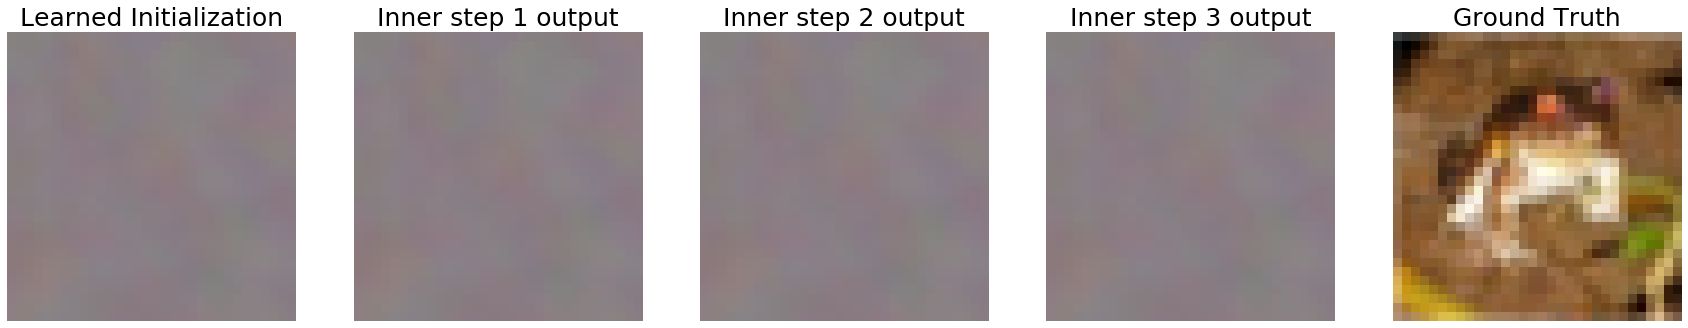

Step 100, Total loss 0.182082


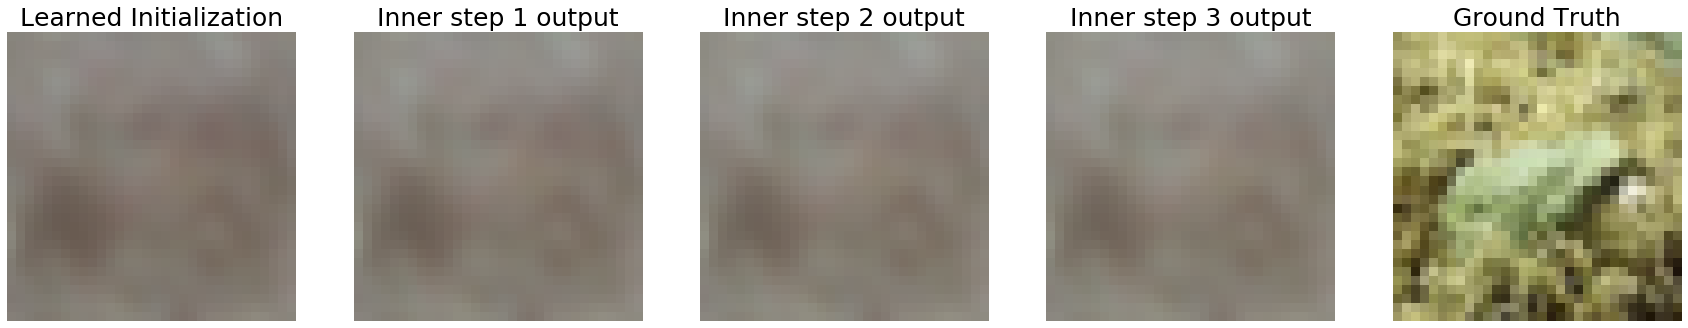

Step 200, Total loss 0.052748


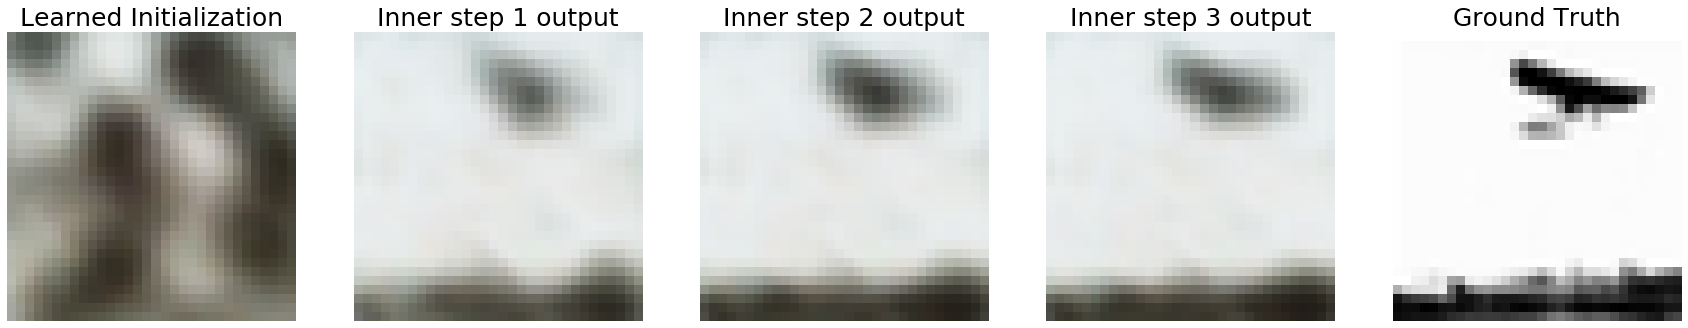

Step 300, Total loss 0.028554


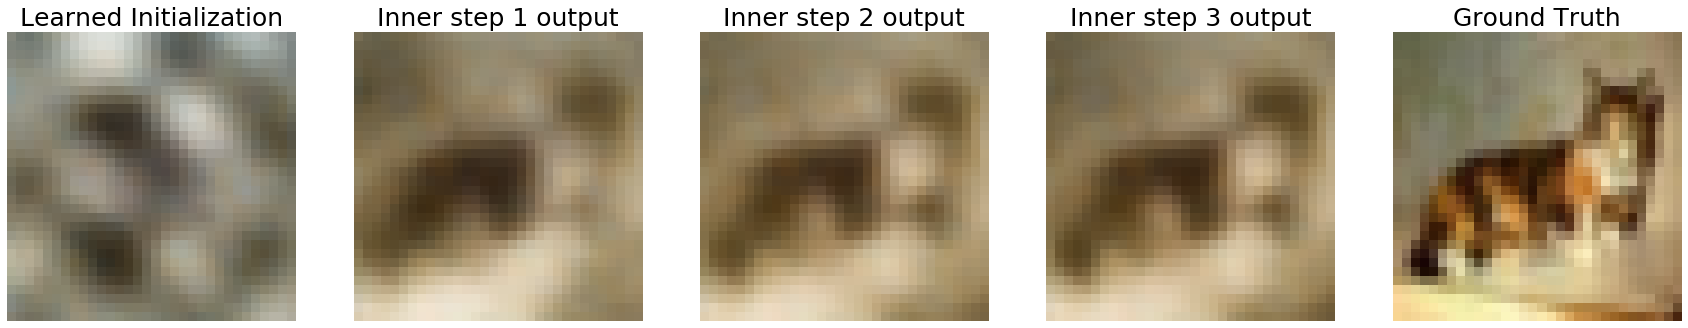

Step 400, Total loss 0.023463


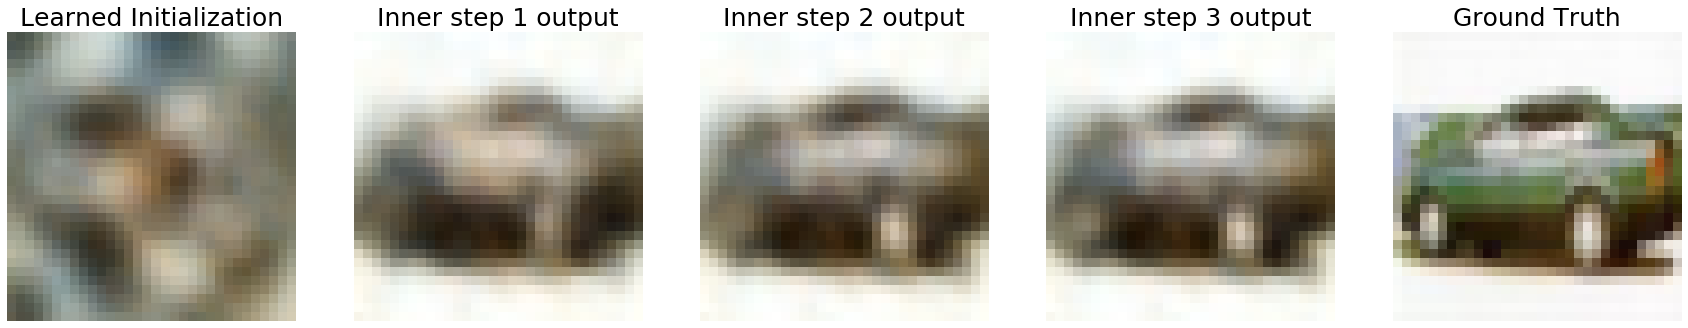

Step 500, Total loss 0.019439


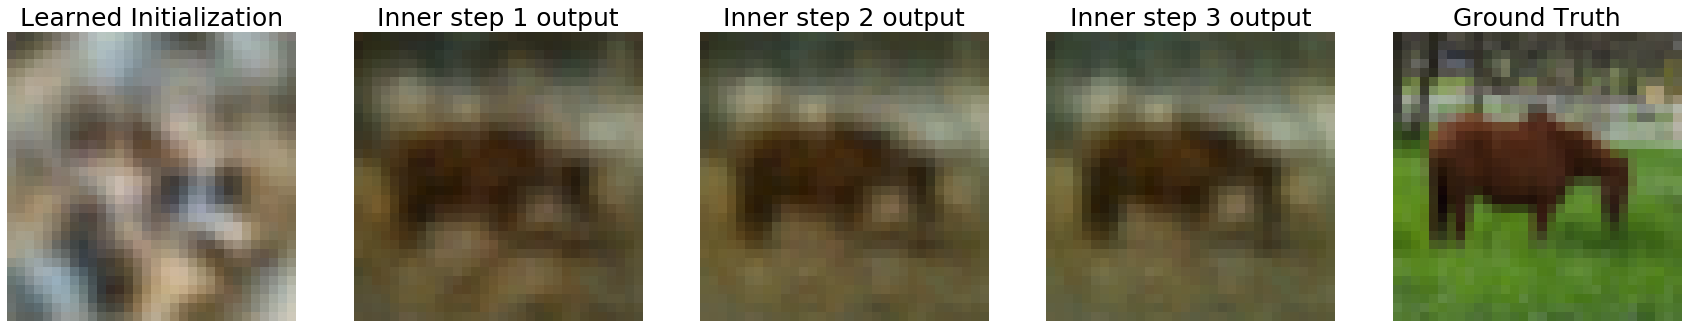

Step 600, Total loss 0.012694


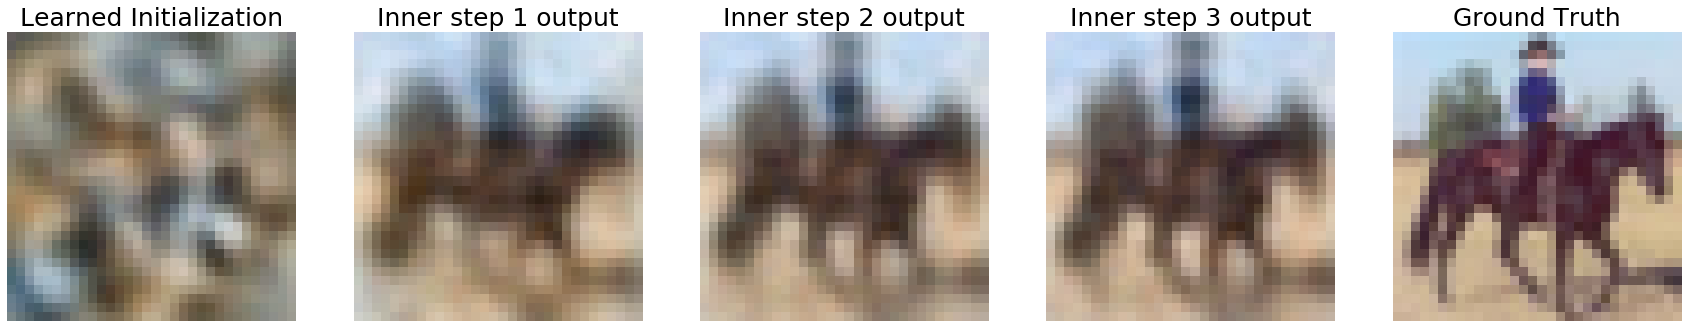

Step 700, Total loss 0.010373


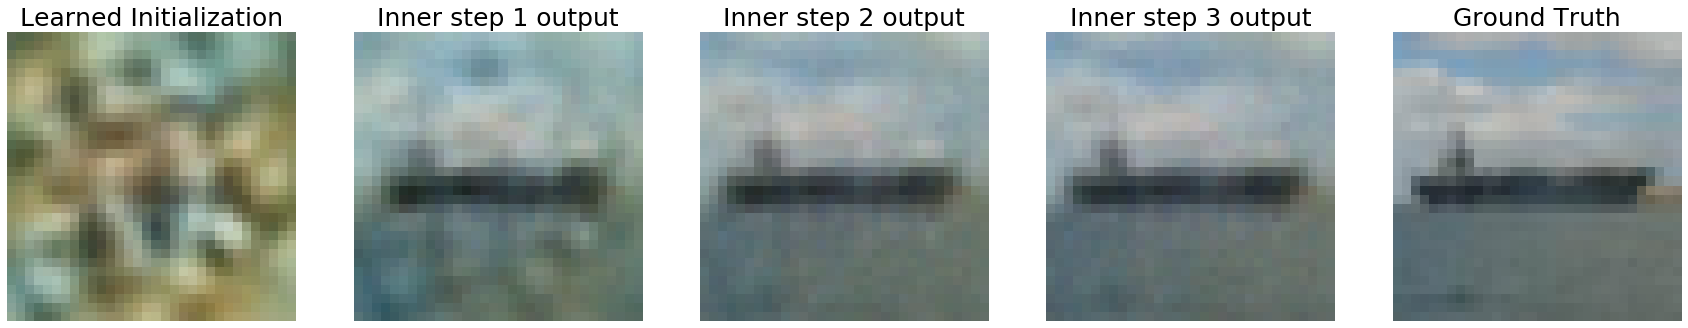

Step 800, Total loss 0.011989


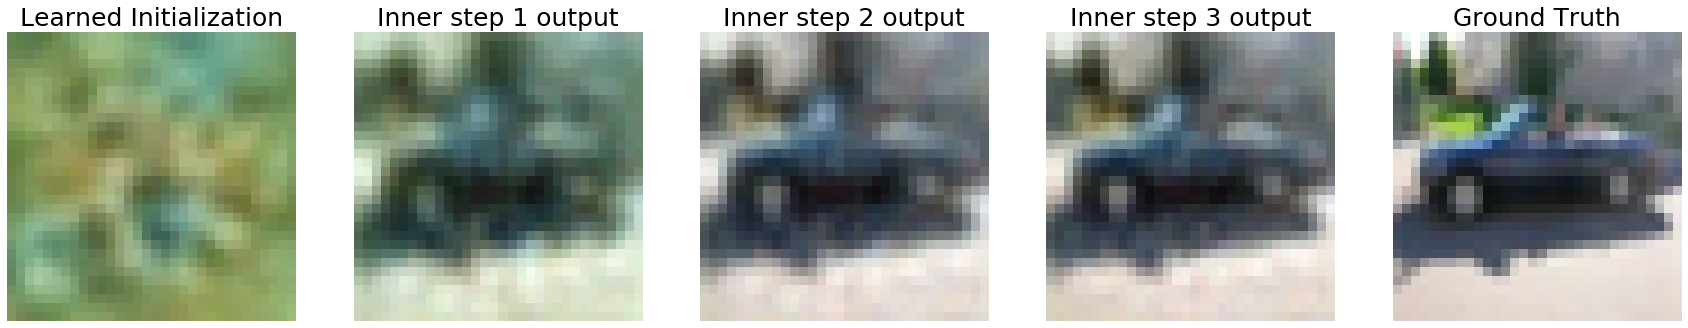

Step 900, Total loss 0.008604


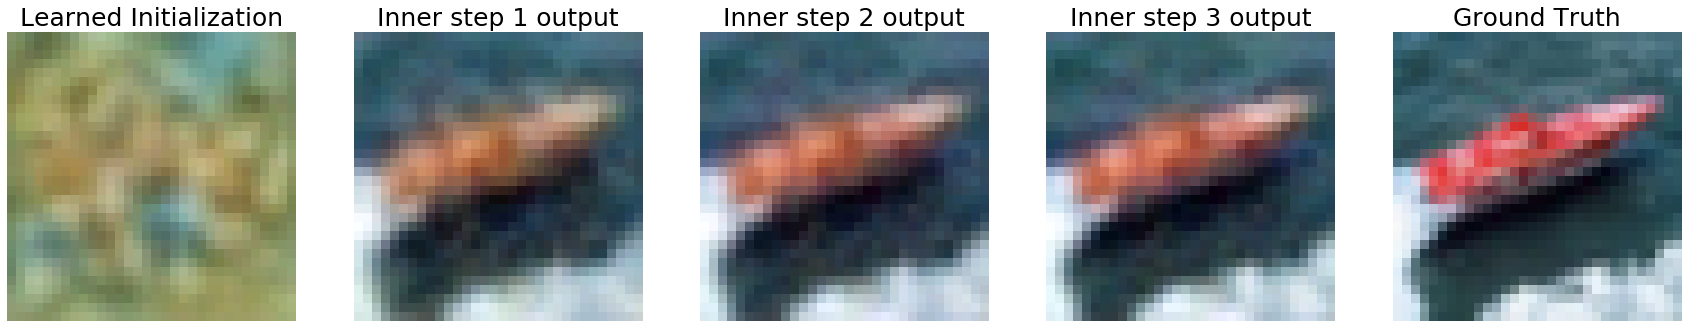

Step 1000, Total loss 0.005997


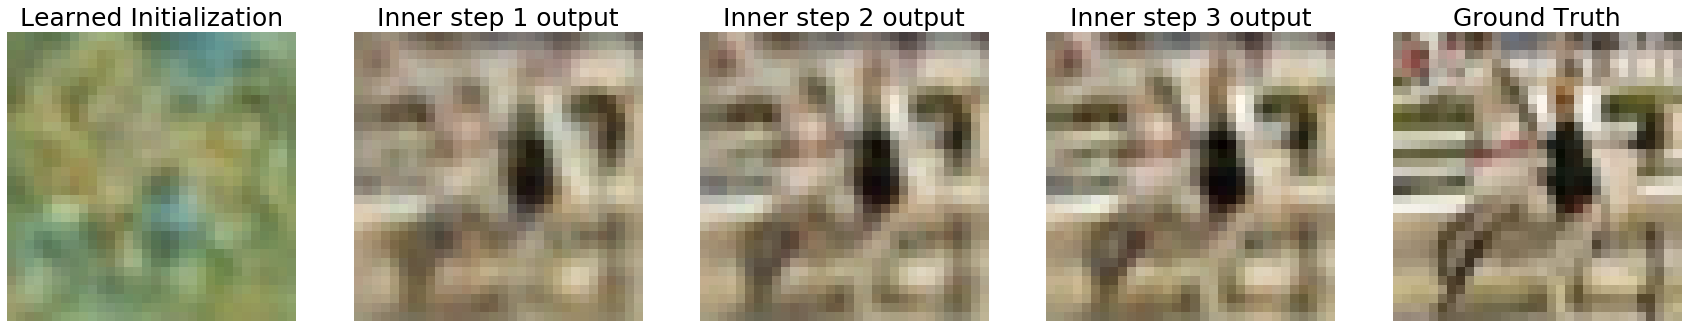

Step 1100, Total loss 0.006402


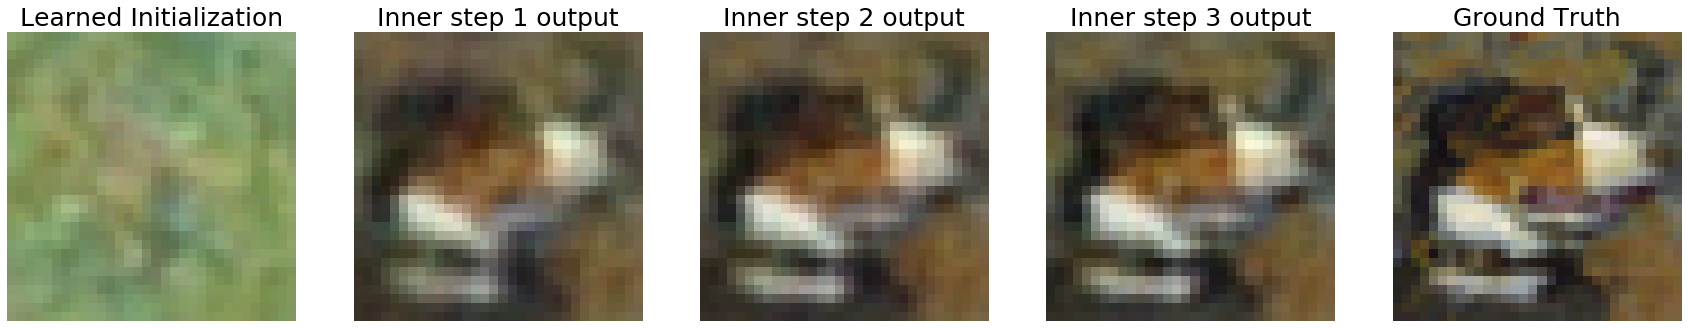

Step 1200, Total loss 0.005798


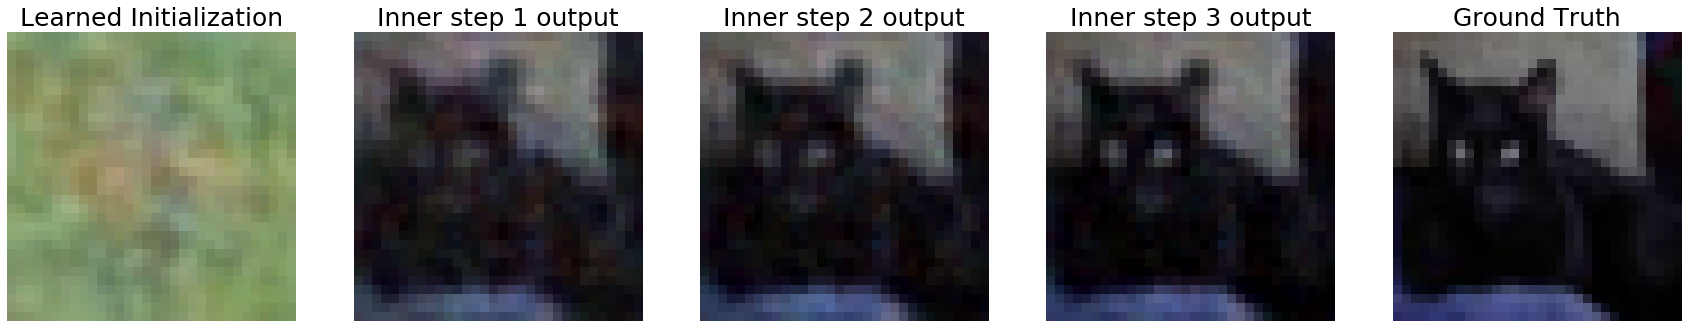

Step 1300, Total loss 0.005281


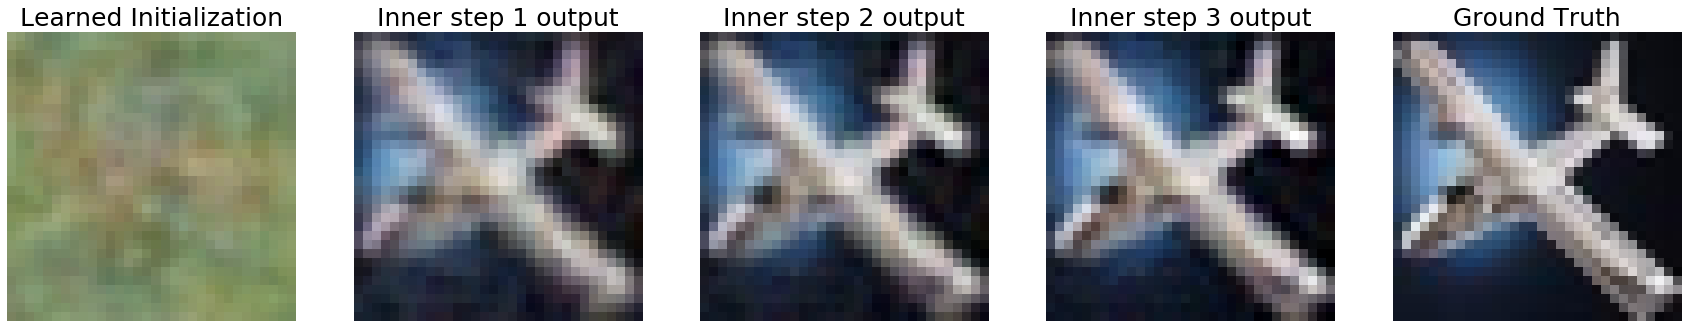

Step 1400, Total loss 0.003771


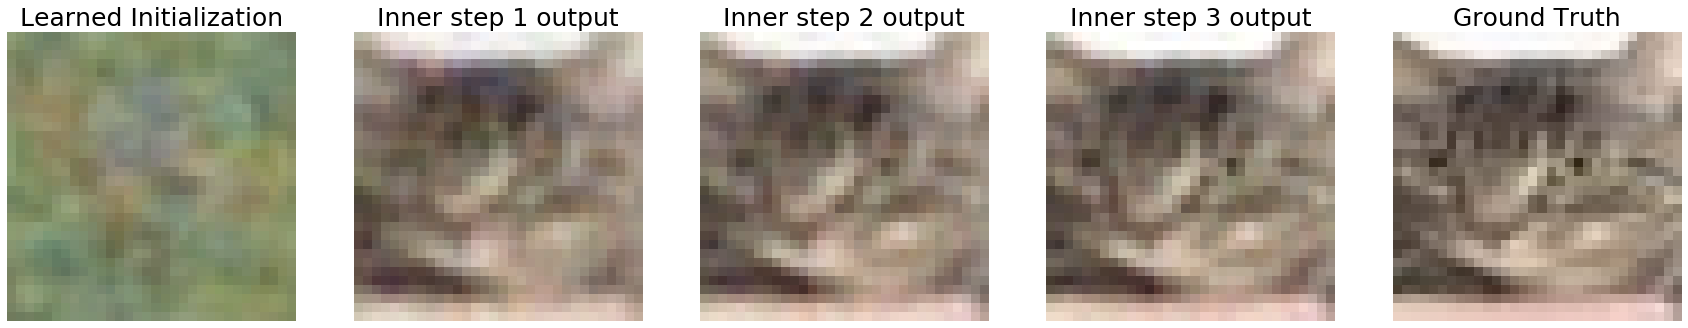

Step 1500, Total loss 0.003479


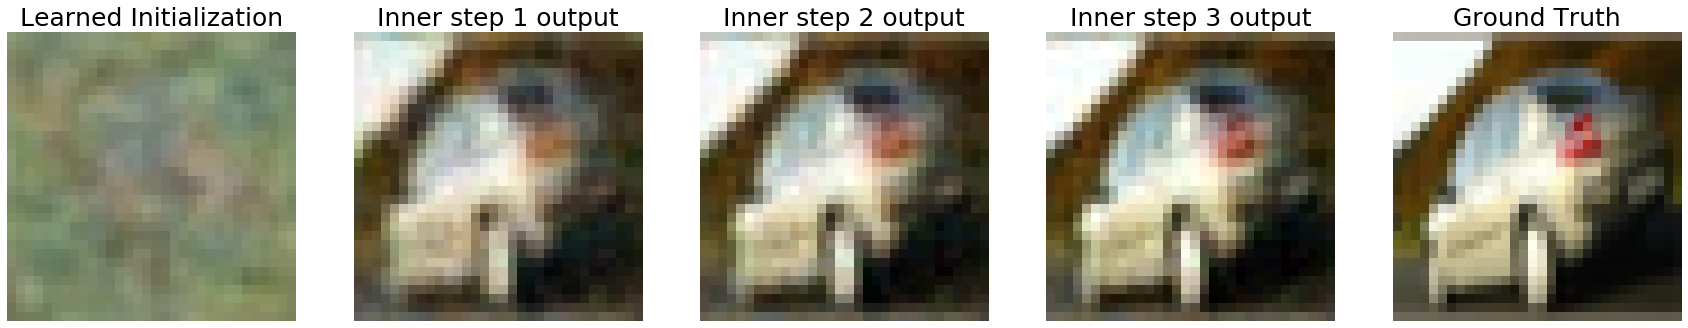

In [14]:
steps_til_summary = 100

optim = torch.optim.Adam(lr=5e-5, params=meta_siren.parameters())

for step, sample in enumerate(dataloader):
    sample = dict_to_gpu(sample)
    model_output = meta_siren(sample)    
    loss = ((model_output['model_out'] - sample['query']['y'])**2).mean()
    
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        fig, axes = plt.subplots(1,5, figsize=(30,6))
        ax_titles = ['Learned Initialization', 'Inner step 1 output', 
                     'Inner step 2 output', 'Inner step 3 output', 
                     'Ground Truth']
        for i, inner_step_out in enumerate(model_output['intermed_predictions']):
            plot_sample_image(inner_step_out, ax=axes[i])
            axes[i].set_title(ax_titles[i], fontsize=25)
        plot_sample_image(model_output['model_out'], ax=axes[-2])
        axes[-2].set_title(ax_titles[-2], fontsize=25)

        plot_sample_image(sample['query']['y'], ax=axes[-1])
        axes[-1].set_title(ax_titles[-1], fontsize=25)

        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()


As you can see, after a few hundred steps of training, we can fit any of the Cifar-10 images in only three gradient descent steps!

<a id='section_2'></a>
## Learning to fit 2D MNIST SDFs

Now, we will see how we can fit 2D SDFs quickly using gradient-based meta-learning.

We will use MNIST as an example, transforming them into 2D signed distance fields, where the contour is the zero-level set.

First, the dataset code:

In [16]:
class SignedDistanceTransform:
    def __call__(self, img_tensor):
        # Threshold.
        img_tensor[img_tensor<0.5] = 0.
        img_tensor[img_tensor>=0.5] = 1.

        # Compute signed distances with distance transform
        img_tensor = img_tensor.numpy()

        neg_distances = scipy.ndimage.morphology.distance_transform_edt(img_tensor)
        sd_img = img_tensor - 1.
        sd_img = sd_img.astype(np.uint8)
        signed_distances = scipy.ndimage.morphology.distance_transform_edt(sd_img) - neg_distances
        signed_distances /= float(img_tensor.shape[1])
        signed_distances = torch.Tensor(signed_distances)

        return signed_distances, torch.Tensor(img_tensor)


class MNISTSDFDataset(torch.utils.data.Dataset):
    def __init__(self, split, size=(256,256)):
        self.transform = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(),
            SignedDistanceTransform(),
        ])
        self.img_dataset = torchvision.datasets.MNIST('./data/MNIST', train=True if split == 'train' else False,
                                                download=True)
        self.meshgrid = get_mgrid(size[0])
        self.im_size = size

    def __len__(self):
        return len(self.img_dataset)

    def __getitem__(self, item):
        img, digit_class = self.img_dataset[item]

        signed_distance_img, binary_image = self.transform(img)
        
        coord_values = self.meshgrid.reshape(-1, 2)
        signed_distance_values = signed_distance_img.reshape((-1, 1))
        
        indices = torch.randperm(coord_values.shape[0])
        support_indices = indices[:indices.shape[0]//2]
        query_indices = indices[indices.shape[0]//2:]

        meta_dict = {'context': {'x':coord_values[support_indices], 'y':signed_distance_values[support_indices]}, 
                     'query': {'x':coord_values[query_indices], 'y':signed_distance_values[query_indices]}, 
                     'all': {'x':coord_values, 'y':signed_distance_values}}

        return meta_dict

Next, we instantiate the dataset:

In [ ]:
train_dataset = MNISTSDFDataset('train', size=(64, 64))
val_dataset = MNISTSDFDataset('val', size=(64, 64))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16)

The losses & a helper function for plotting:

In [18]:
def sdf_loss(predictions, gt):
    return ((predictions - gt)**2).mean()


def inner_maml_sdf_loss(predictions, gt):
    return ((predictions - gt)**2).sum(0).mean()

Next, the initialization scheme proposed by Atzmon et al. 2020:

In [19]:
def sal_init(m):
    if type(m) == BatchLinear or nn.Linear:
        if hasattr(m, 'weight'):
            std = np.sqrt(2) / np.sqrt(_calculate_correct_fan(m.weight, 'fan_out'))

            with torch.no_grad():
                m.weight.normal_(0., std)
        if hasattr(m, 'bias'):
            m.bias.data.fill_(0.0)


def sal_init_last_layer(m):
    if hasattr(m, 'weight'):
        val = np.sqrt(np.pi) / np.sqrt(_calculate_correct_fan(m.weight, 'fan_in'))
        with torch.no_grad():
            m.weight.fill_(val)
    if hasattr(m, 'bias'):
        m.bias.data.fill_(0.0)

For this task, we use a simple model with two hidden layers of 256 hidden units. We use the original MAML algorithm with 3 steps and a single learnable LR initialized to 1e-1.

In [20]:
hypo_module = MetaFC(in_features=2, out_features=1, 
                     num_hidden_layers=2, hidden_features=256, 
                     outermost_linear=True)
hypo_module.apply(sal_init)
hypo_module.net[-1].apply(sal_init_last_layer)
model = MAML(num_meta_steps=3, hypo_module=hypo_module, loss=inner_maml_sdf_loss, init_lr=1e-5, 
             lr_type='global').cuda()

132610


Now, we're ready for training!

In [ ]:
optim = torch.optim.Adam(lr=1e-4, params=model.parameters())

train_losses = []
val_losses = []

for epoch in range(3):
    for step, meta_batch in enumerate(train_dataloader):
        model.train()        
        meta_batch = dict_to_gpu(meta_batch)

        # Adapt model using context examples
        fast_params, _ = model.generate_params(meta_batch['context'])
        
        # Use the adapted examples to make predictions on query
        pred_sd = model.forward_with_params(meta_batch['query']['x'], fast_params)
        
        # Calculate loss on query examples
        loss = sdf_loss(pred_sd, meta_batch['query']['y'].cuda())
        train_losses.append(loss.item())

        optim.zero_grad()
        loss.backward()
        optim.step()

        if step % 100 == 0:
            # Assemble validation input
            meta_batch['context']['x'] = meta_batch['query']['x'] = meta_batch['all']['x']
            meta_batch['context']['y'] = meta_batch['query']['y'] = meta_batch['all']['y']

            with torch.no_grad():
                model_output = model(meta_batch)

            print("Step %d, Total loss %0.6f" % (step, loss))
            fig, axes = plt.subplots(1,5, figsize=(30,6))
            ax_titles = ['Learned Initialization', 'Inner step 1 output', 
                        'Inner step 2 output', 'Inner step 3 output', 
                        'Ground Truth']
            for i, inner_step_out in enumerate(model_output['intermed_predictions']):
                plot_sample_image(inner_step_out, ax=axes[i])
                axes[i].set_axis_off()
                axes[i].set_title(ax_titles[i], fontsize=25)
            plot_sample_image(model_output['model_out'], ax=axes[-2])
            axes[-2].set_axis_off()
            axes[-2].set_title(ax_titles[-2], fontsize=25)

            plot_sample_image(meta_batch['query']['y'], ax=axes[-1])
            axes[-1].set_axis_off()
            axes[-1].set_title(ax_titles[-1], fontsize=25)
            plt.show()


In [ ]:
with torch.no_grad():
    model.eval()
    for step, meta_batch in enumerate(val_dataloader):
        # Instead of explicitly calling generate_params and forward_with_params,
        # we can pass the meta_batch dictionary to the model's forward method
        pred_sd = model(meta_batch)
        val_loss = sdf_loss(pred_sd['model_out'], meta_batch['query']['y'].cuda())
        val_losses.append(val_loss.item())
        
        if step % 1000 == 0:
            pred_image = model.forward_with_params(meta_batch['all']['x'].cuda(), fast_params)
            print(f"Val Image -- Epoch: {epoch} \t step: {step} \t loss: {loss.item()}")
            print(pred_image.shape)
            plt.imshow(lin2img(pred_image).cpu().numpy()[0][0])
            plt.show()